In [49]:
import pickle
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import pyemma as pe
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelBinarizer
from graphtime.markov_random_fields import estimate_dMRF
from graphtime.utils import simulate_MSM as generate
import itertools
import math
import random

In [8]:
import sys
sys.path.append('../../')
from dim_pucker.utils import complemetary

<font size="3">Following method reads pucker angle data of all the NAs of available DNA sequences: <code><br>(both the strnds are read 5-3)</code> </font>

In [9]:
def get_data(seq):
    data = np.loadtxt(f'../../../Pucker/Data/{seq}/pucker.dat')
    data1 = np.loadtxt(f'../../../Pucker/Data/{seq}/pucker1.dat') # data recorded 3-5
    data = data[:,1:]
    data1 = np.flip(data1[:,1:], axis=1) # make data 5-3
    combined_data = np.hstack((data, data1))
    combined_data = np.array([combined_data[:, i] for i in range(36)]).T
    return(combined_data)

<font size="3">Read the names of the DNA sequences as described in <code>https://doi.org/10.1093/nar/gku855</code> : <code>gc-CD-ABCD-ABCD-ABCD-gc</code></font>

In [10]:
list_labels = os.listdir('../../../Pucker/Data/')
list_labels.remove('script.sh')

<font size="3">Create a dictionary of all possible tetramer combinations: <code>-CD-ABCD-ABCD-ABCD-</code> excluding terminals</font>

In [14]:
# def get_all_tetramers(seq):
#     full_seq =  ''.join([seq[2:],seq,seq,seq])
#     arr = []
#     for i in range(len(full_seq)-3):
#         tetramer = ''.join([full_seq[i],full_seq[i+1],full_seq[i+2],full_seq[i+3]])
#         if not(tetramer in arr):
#             arr.append(tetramer)
#     return(arr)

# dic_tetramers = {}

# for seq in list_labels:
#     for tetramer in get_all_tetramers(seq):
#         if not(tetramer in dic_tetramers):
#             dic_tetramers[tetramer] = []
#     for tetramer in get_all_tetramers(complemetary(seq)):
#         if not(tetramer in dic_tetramers):
#             dic_tetramers[tetramer] = []

<font size="3">Create 2 dictionaries of all possible 5-terminals <code>[GC-**X**]</code> and 3-terminals<code>[**X**-GC]</code>: </font>

In [15]:
# dic_5ter = {}
# dic_3ter = {}

# for i in 'ATGC':
#     dic_5ter[''.join(['GC',i])] = []
#     dic_3ter[''.join([i,'GC'])] = []

<font size="3">Following method asigns pucker:<br>
> <code>(72>P>300: North Pucker : +1)</code><br>
> <code>(72<=P<=300: South Pucker : -1)</code></font>

In [16]:
# North = 1, South = -1

def pucker_assign(arr):
    temp_arr = np.zeros_like(arr)
    temp_arr[:] = -1
    temp_arr[arr < 72]  = 1
    temp_arr[arr > 300] = 1
    return(temp_arr.astype(int))

<font size=3>Use different lag-times(𝜏) after inspecting implied time scales.</font> 

In [51]:
all_data = []
for i in list_labels: 
    all_data.append(get_data(i))
              
pucker_all = []
for i in all_data:
    pucker_all.append(pucker_assign(i))

/Users/nami/miniconda3/envs/p2/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/nami/miniconda3/envs/p2/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 4/4 [00:00<00:00,  7.06it/s]                        
/Users/nami/miniconda3/envs/p2/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/nami/miniconda3/envs/p2/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
/Users/nami/miniconda3/envs/p2/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 12/12 [00:00<00:00, 

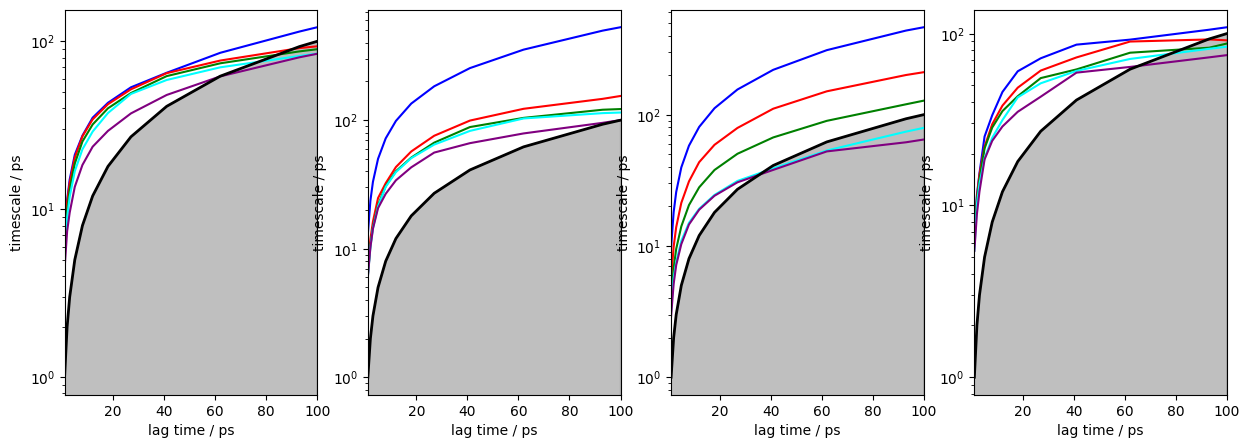

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(15,5))
n=0
for i in random.sample(range(1,40),4):
    tica = pe.coordinates.tica(pucker_all[i], lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    cluster = pe.coordinates.cluster_kmeans(tica_output, k=300, max_iter=50, stride=10, fixed_seed=1)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    
    its = pe.msm.its(cluster.dtrajs, lags=100, nits=5, errors=None)
    pe.plots.plot_implied_timescales(its, units='ps', dt=1, ylog=True, ax=ax[n]);
    n+=1

In [55]:
pucker_all[0].shape

(1001000, 36)

In [89]:
lags = [20, 50, 100]
logistic_regression_kwargs={'fit_intercept': True, 'penalty': 'l1', 'C': 1.0, 'tol': 0.00001, 'solver': 'saga', 'max_iter': 500}

for lag in lags:
    dmrfs_ = {} # tetramer dmrf objects
    dmrfs_5 = {} # terminal 5 dmrf objects
    dmrfs_3 = {} # terminal 3 dmrf objects
    # dmrf_arr = []
    for seq_no, seq in enumerate(list_labels):
        full_seq = 'GC'+seq[2:]+seq*3+'GC' + complemetary('GC'+seq[2:]+seq*3+'GC') # 5-3 seq + 5-3 comp_seq
        x = np.arange(len(full_seq))
        # print(full_seq)
        for i in range(int((len(full_seq)/2)-7)):
            s = full_seq[2:-2][i:i+4]
            # print(s)
            data_index = list(np.concatenate((x[2:-2][i+1:i+3], x[2:-2][-i-3:-i-1]))) # index of the middle 2 NA+comp_NA (4 columns of pucker data)
            dmrf = estimate_dMRF(strajs=[pucker_all[seq_no][:,data_index]], lag=lag, Encoder=LabelBinarizer(neg_label = -1, pos_label = 1),
                                 logistic_regression_kwargs=logistic_regression_kwargs)
            # dmrf_arr.append(dmrf)
            try:
                dmrfs_[s].append(dmrf)
            except:
                dmrfs_[s] = []
                dmrfs_[s].append(dmrf)
                
        s5 = full_seq[:3]
        data_index = list(np.concatenate((x[:2],x[-2:])))
        dmrf5 = estimate_dMRF(strajs=[pucker_all[seq_no][:,data_index]], lag=lag, Encoder=LabelBinarizer(neg_label = -1, pos_label = 1),
                             logistic_regression_kwargs=logistic_regression_kwargs)
        
        s3 = full_seq[15:18]
        data_index = list(x[15:21])
        dmrf3 = estimate_dMRF(strajs=[pucker_all[seq_no][:,data_index]], lag=lag, Encoder=LabelBinarizer(neg_label = -1, pos_label = 1),
                             logistic_regression_kwargs=logistic_regression_kwargs)
        
        try:
            dmrfs_5[s5].append(dmrf5)
            dmrfs_3[s3].append(dmrf3)
        except:
            dmrfs_5[s5] = []
            dmrfs_3[s3] = []
            dmrfs_5[s5].append(dmrf5)
            dmrfs_3[s3].append(dmrf3)
        
            
    with open(f'dmrf_tetramer_{int(lag)}.dmrf', 'wb') as f:
        pickle.dump(dmrfs_, f)
        
    with open(f'dmrf_5_{int(lag)}.dmrf', 'wb') as f:
        pickle.dump(dmrfs_5, f)
        
    with open(f'dmrf_3_{int(lag)}.dmrf', 'wb') as f:
        pickle.dump(dmrfs_3, f)